# MLP Modeling - 7

with hugging face api

In [1]:
import os
from datetime import datetime as dt

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sentence_transformers import SentenceTransformer
# import optuna

2023-04-28 08:17:23.348314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 08:17:24.258361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-28 08:17:24.258481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such fi

In [2]:
# model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

## load data

In [3]:
train_df = pd.read_csv("open/train.csv", index_col='ID')
test_df = pd.read_csv("open/test.csv", index_col='ID')
sample_submission_df = pd.read_csv("open/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((871393, 9), (159621, 8), (159621, 2))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871393 entries, TRAIN_000000 to TRAIN_871392
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              871393 non-null  object 
 1   Book-ID              871393 non-null  object 
 2   Book-Rating          871393 non-null  int64  
 3   Age                  871393 non-null  float64
 4   Location             871393 non-null  object 
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  float64
 8   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 66.5+ MB


## preprocess data

In [5]:
train_users = train_df['User-ID'].unique()
train_books = train_df['Book-ID'].unique()

len(train_users), len(train_books)

(83256, 243441)

In [6]:
test_users = test_df['User-ID'].unique()
test_books = test_df['Book-ID'].unique()

len(test_users), len(test_books)

(21909, 62333)

In [7]:
len(set(train_users) | set(test_users)), len(set(train_books) | set(test_books))

(92101, 270056)

새로운 유저, 새로운 책이 분명 있음

In [8]:
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
ID,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


User feature
 * Age: int
 * Location: string

Book feature
 * Book-Title: string
 * Book-Author: string
 * Year-Of-Pulication: int
 * Publisher: string

특징의 분해 이전에 label 형태로도 해볼 수 있음

# Feature Selection

In [9]:
features = test_df.columns
features

Index(['User-ID', 'Book-ID', 'Age', 'Location', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher'],
      dtype='object')

In [10]:
continuous_features = ['Age', 'Year-Of-Publication']
categorical_features = ['Location', 'Book-Title', 'Book-Author', 'Publisher']

In [11]:
train_df['Location'] = train_df['Location'].str.replace(' ', '')
train_df['Location_country'] = train_df['Location'].apply(lambda x: x.split(',')[-1])
train_df['Location_city'] = train_df['Location'].apply(lambda x: x.split(',')[-2])
train_df.drop(columns='Location', inplace=True)
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,Road Taken,Rona Jaffe,2001.0,Mira,canada,newbrunswick
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,canada,newbrunswick
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,canada,newbrunswick


In [12]:
test_df['Location'] = test_df['Location'].str.replace(' ', '')
test_df['Location_country'] = test_df['Location'].apply(lambda x: x.split(',')[-1])
test_df['Location_city'] = test_df['Location'].apply(lambda x: x.split(',')[-2])
test_df.drop(columns='Location', inplace=True)
test_df.head()

,User-ID,Book-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,
TEST_000000,USER_00008,BOOK_047966,37.0,Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon,usa,ohio
TEST_000001,USER_00008,BOOK_119494,37.0,Midnight Voices,JOHN SAUL,2003.0,Ballantine Books,usa,ohio
TEST_000002,USER_00008,BOOK_151775,37.0,Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass,usa,ohio
TEST_000003,USER_00008,BOOK_176255,37.0,Bitter Harvest,Ann Rule,1999.0,Pocket,usa,ohio
TEST_000004,USER_00008,BOOK_187307,37.0,Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books,usa,ohio


# Embedding with huggingface api

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L3-v2")

/opt/conda/envs/general/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
book_title_encoded = np.zeros(shape=(train_df.shape[0], 384), dtype='float32')
book_title_encoded.shape

(871393, 384)

In [16]:
# 아마 array로 나올 것
# train_df['Book-Title'].apply(lambda x: model.encode(x)) # 이대로는 안된다 너무 너무 너무 * 10000000000으로 느림 (데이터 크기가 엄청난 듯) sentence 말고 다른 것 없나?
for i, row in tqdm(enumerate(train_df['Book-Title']), total=train_df.shape[0]):
    book_title_encoded.put(i, model.encode(row))

 16%|█▌        | 137939/871393 [11:22<1:00:57, 200.55it/s]

- https://huggingface.co/blog/getting-started-with-embeddings
- https://anpigon.tistory.com/387
- https://huggingface.co/docs/transformers/preprocessing

# encoding

for location_country, publisher

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
cont_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
train_country_array = cont_encoder.fit_transform(train_df[['Location_country']]).toarray()
test_country_array = cont_encoder.transform(test_df[['Location_country']]).toarray()

In [14]:
# pub_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
# train_publisher_array = pub_encoder.fit_transform(train_df[['Publisher']]).toarray()
# test_publisher_array = pub_encoder.transform(train_df[['Publisher']]).toarray()

# scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
train_cont_array = scaler.fit_transform(train_df[continuous_features])
test_cont_array = scaler.transform(test_df[continuous_features])

# merge prcessed data

In [17]:
train_cont_array.shape, train_country_array.shape, train_publisher_array.shape

((871393, 2), (871393, 243), (871393, 15505))

In [18]:
# train_x = {
#     'input_continuous': train_cont_array,
#     'input_country': train_country_array,
# }

# test_x = {
#     'input_continuous': test_cont_array,
#     'input_country': test_country_array,
# }

train_x = [train_cont_array, train_country_array, train_publisher_array]
test_x = [test_cont_array, test_country_array, test_publisher_array]

In [19]:
# train_x = np.concatenate([train_cont_array, train_df[['Location_country']].values], axis=1) #train_publisher_array
# test_x = np.concatenate([test_cont_array, test_df[['Location_country']].values], axis=1) #test_publisher_array

# train_x.shape, test_x.shape

In [20]:
train_y = train_df['Book-Rating'].values
train_y.shape

(871393,)

In [21]:
# train_array = np.concatenate([train_cont_array, train_country_array, train_publisher_array], axis=1)
# test_array = np.concatenate([test_cont_array, test_country_array, test_publisher_array], axis=1)

# model

In [22]:
alpha = 0.001

In [23]:
train_country_array.shape[1]

243

In [24]:
def build_custom_model(input_dims):
    # define input tensor
    input_continuous = tf.keras.Input(shape=input_dims[0], dtype=tf.float32)
    input_country = tf.keras.Input(shape=input_dims[1], dtype='bool')
    input_publisher = tf.keras.Input(shape=input_dims[2], dtype='bool')

    # embedding layer
    embed_country_layer = tf.keras.layers.Embedding(
        train_country_array.shape[1], 10)(input_country)

    # rnn layer
    country_layer = tf.keras.layers.SimpleRNN(
        10, return_sequences=False, dtype=np.float32)(embed_country_layer)

    # embedding layer
    embed_publisher_layer = tf.keras.layers.Embedding(
        train_country_array.shape[1], 10)(input_publisher)

    # rnn layer
    publisher_layer = tf.keras.layers.SimpleRNN(
        10, return_sequences=False, dtype=np.float32)(embed_publisher_layer)

    # concatenate
    x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, country_layer, publisher_layer])
    # # concatenate
    # x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, input_country])

    # hidden layer
    x = tf.keras.layers.Dense(
        64, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # hidden layer
    x = tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # output layer
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model([input_continuous, input_country, input_publisher], x)

    return model

In [25]:
learning_rate = 0.001
batch_size = 1000
epochs = 100

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = build_custom_model(input_dims=[
        train_cont_array.shape[1], 
        train_country_array.shape[1], 
        train_publisher_array.shape[1]]
    )

    # define optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # model compile
    model.compile(optimizer=optimizer, loss='mse', metrics='mse')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 243)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 15505)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 243, 10)      2430        ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 15505, 10)    2430        ['input_3[0][0]']                
                                                                                              

In [28]:
history = model.fit(train_x, train_y, validation_split=.1, epochs=epochs, batch_size=batch_size)

2023-04-27 08:11:00.209145: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12159842765 exceeds 10% of free system memory.
2023-04-27 08:11:07.124747: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12159842765 exceeds 10% of free system memory.
2023-04-27 08:11:11.572765: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12159842765 exceeds 10% of free system memory.


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

2023-04-27 08:11:59.595088: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 591.47MiB (rounded to 620200192)requested by op concat_6
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-27 08:11:59.595291: W tensorflow/tsl/framework/bfc_allocator.cc:492] *********************************************************************************************_***___
2023-04-27 08:11:59.595326: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at concat_op.cc:163 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[15505000,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: Graph execution error:

Detected at node 'concat_6' defined at (most recent call last):
    File "/opt/conda/envs/general/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/envs/general/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_362/1603424062.py", line 1, in <module>
      history = model.fit(train_x, train_y, validation_split=.1, epochs=epochs, batch_size=batch_size)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 175, in _all_reduce_sum_fn
      return distribution.extended.batch_reduce_to(
Node: 'concat_6'
Detected at node 'concat_6' defined at (most recent call last):
    File "/opt/conda/envs/general/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/envs/general/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/opt/conda/envs/general/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/envs/general/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_362/1603424062.py", line 1, in <module>
      history = model.fit(train_x, train_y, validation_split=.1, epochs=epochs, batch_size=batch_size)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/general/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 175, in _all_reduce_sum_fn
      return distribution.extended.batch_reduce_to(
Node: 'concat_6'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[15505000,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concat_6}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[update_0_14/AssignAddVariableOp/_237]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[15505000,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concat_6}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7164]

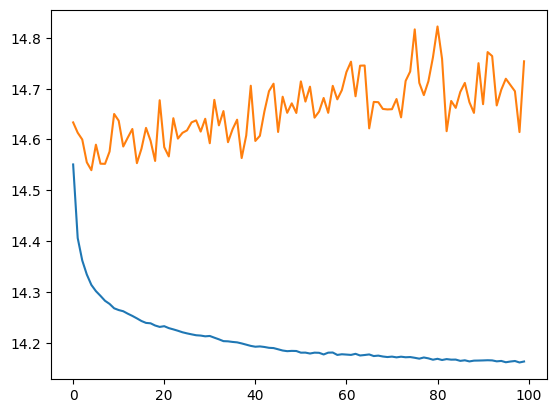

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [36]:
train_pred = model.evaluate(train_x, test_x)
train_pred

2023-04-27 07:09:00.372617: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 13510948465 exceeds 10% of free system memory.
2023-04-27 07:09:15.131951: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.58GiB (rounded to 13510948608)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-27 07:09:15.132095: W tensorflow/tsl/framework/bfc_allocator.cc:492] *_____________________________________________________________________________________***___________


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
train_pred.shape

(871393, 1)

In [33]:
test_pred = model.predict(test_x)
test_pred

4989/4989 [==============================] - 6s 1ms/step


array([[2.8391378],
       [2.8713033],
       [2.6461456],
       ...,
       [3.2239828],
       [3.5754986],
       [3.8391364]], dtype=float32)

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
rmse = mean_squared_error(train_y, train_pred, squared=False)
rmse

3.8036542165822924

In [36]:
sample_submission_df = pd.read_csv("open/sample_submission.csv")
sample_submission_df

,ID,Book-Rating
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0
...,...,...
159616,TEST_159616,0
159617,TEST_159617,0
159618,TEST_159618,0
159619,TEST_159619,0


In [37]:
mname = 'custom_dl'

In [38]:
def make_report(template, test_pred, mname):
    template['Book-Rating'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'results/{mname}-{now}.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

test_rmse = 3.8036542165822924